In [54]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import warnings

warnings.filterwarnings(action='once')

data_dir = './data/london'
cols = [ str(n) for n in range(0, 40) ]
X = pd.read_csv(os.path.join(data_dir, 'train.csv'), names=cols)
Y = pd.read_csv(os.path.join(data_dir, 'trainLabels.csv'), names=['target'])
Y = Y['target']

In [55]:
print(X.shape)
print(Y.shape)

(1000, 40)
(1000,)


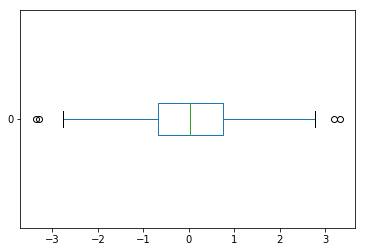

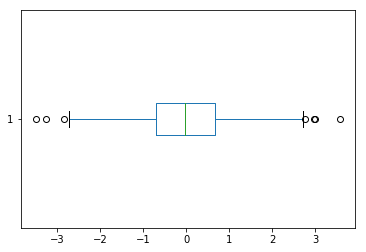

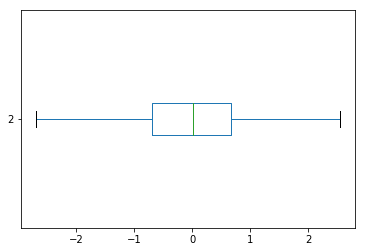

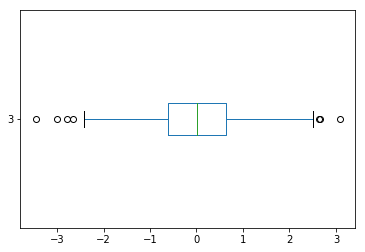

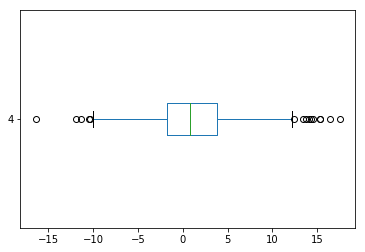

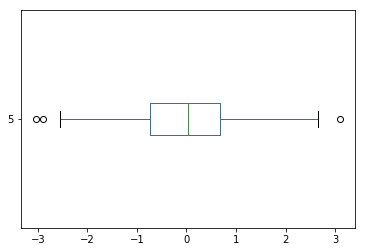

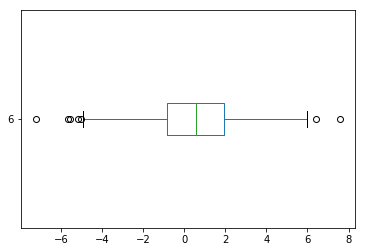

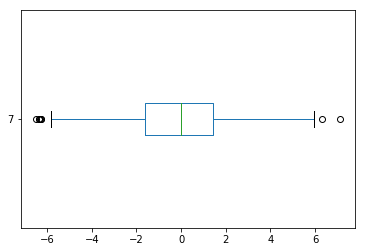

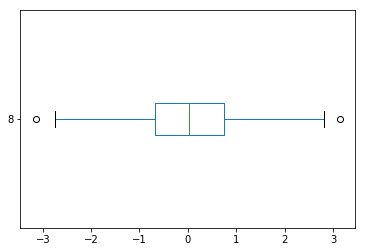

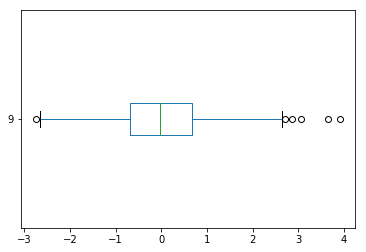

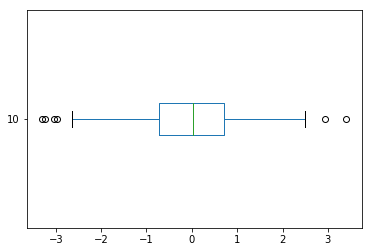

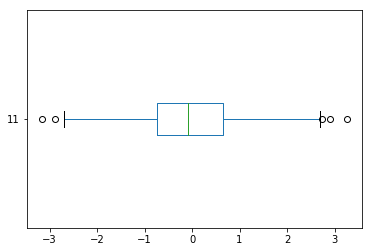

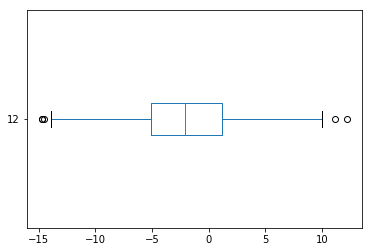

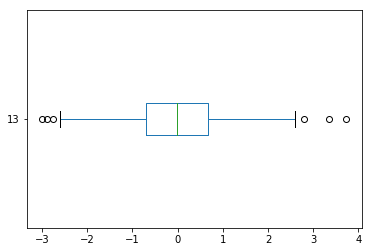

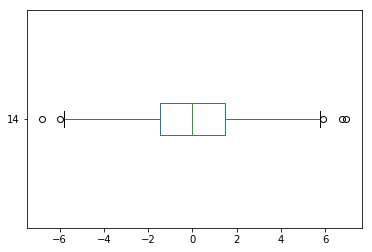

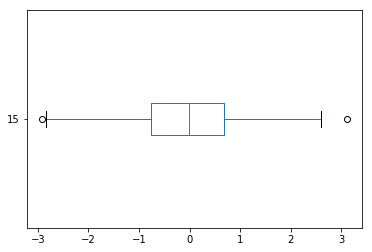

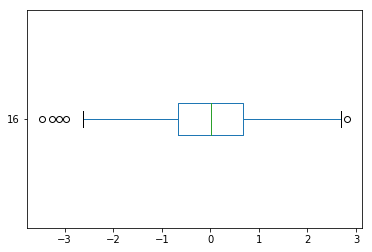

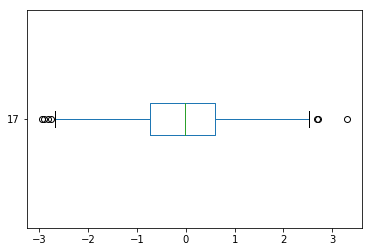

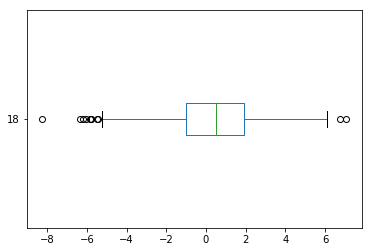

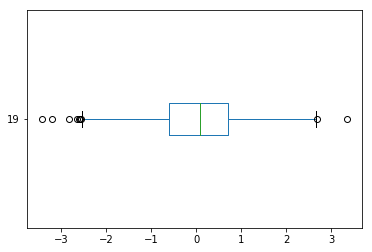

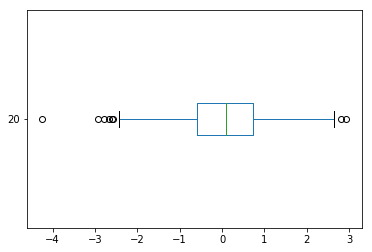

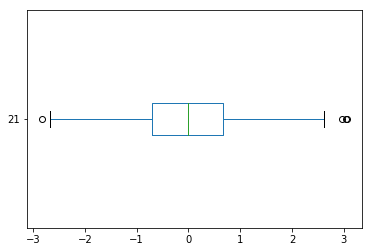

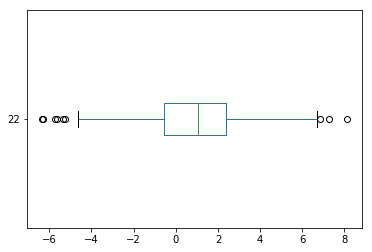

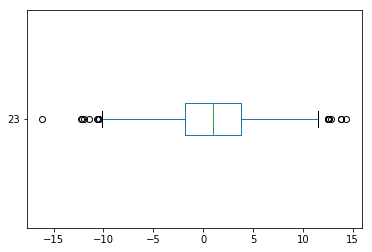

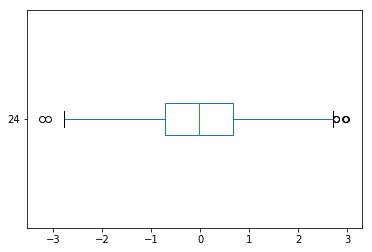

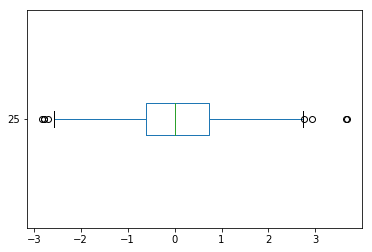

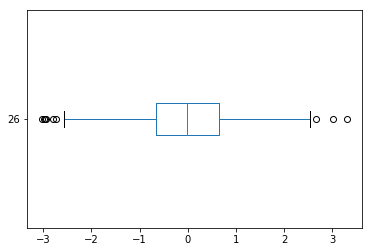

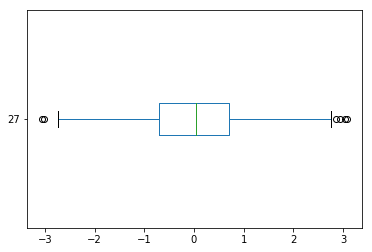

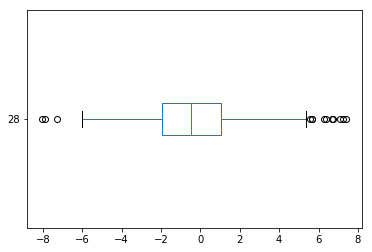

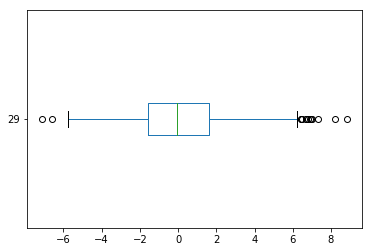

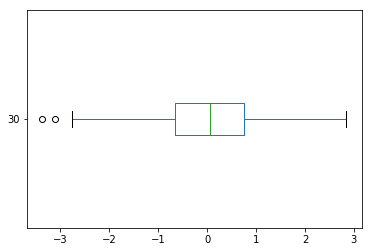

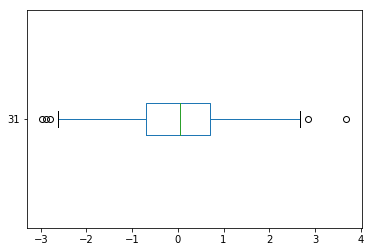

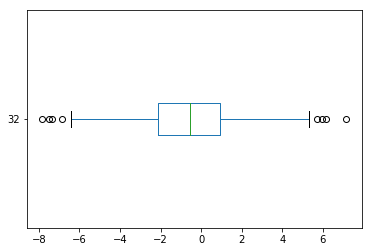

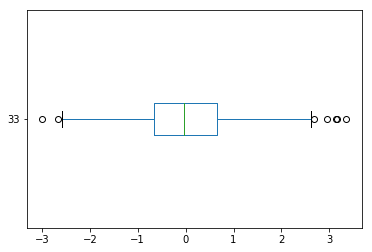

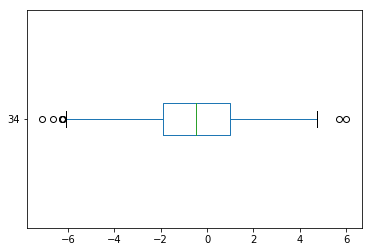

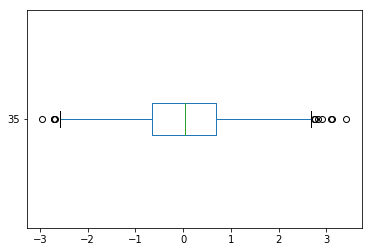

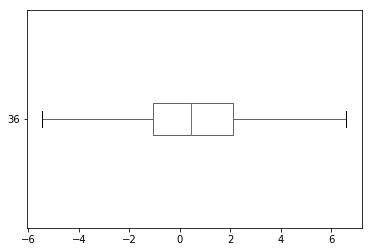

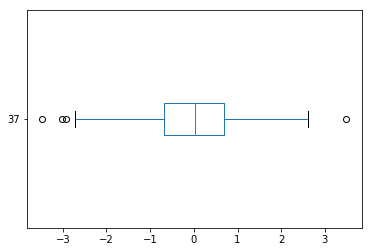

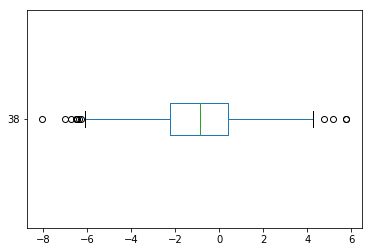

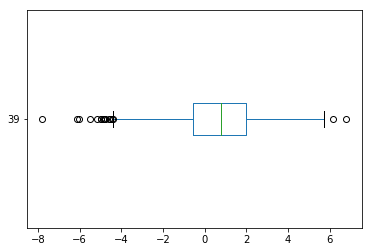

In [56]:
for col in X.columns:
    X[col].plot.box(vert=False)
    plot.show()

In [57]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [60]:
def transform(X, fill, scaler):
    for col in X.columns:
        if type(fill).__name__ == 'function':
            X[col] = fill(X[col])
        else:
            X[col] = X[col].fillna(fill)

        if scaler != None:
            s = scaler()
            X[col] = s.fit_transform(X[col].values.reshape(-1, 1))

    return X

# 交叉測試
def compute_score(model, data, target):
    return cross_val_score(model, data, target, cv=5, error_score='raise').mean()

# 用來顯示測試結果
class Result:
    def __init__(self):
        self.result_columns = ['Estimator', 'Args', 'Filling', 'Scaler', 'Score']
        self.result = pd.DataFrame(columns=self.result_columns)

    def append(self, model, args, fill_name, scaler, score):
        if scaler != None:
            scaler = scaler()
        
        row = pd.DataFrame([[
            type(model).__name__,                                       # 模型
            args,                                                                # 參數
            fill_name,                                                          # 填補值
            type(scaler).__name__ if scaler != None else '-',    # scaler
            score                                                               # 分數
        ]], columns=self.result_columns)
        
        self.result = self.result.append(row, ignore_index=True, sort=True)
    
    def show(self):
        # 按照分數排序
        return self.result.sort_values(by=['Score'], ascending=False)

In [65]:
fills = {
    '-1': -1,
    'zero': 0,
    'mean': lambda x: getattr(x, 'mean')(),
    'median': lambda x: getattr(x, 'median')(),
    'max': lambda x: getattr(x, 'max')(),
    'min': lambda x: getattr(x, 'min')(),
}

scalers = [None, MinMaxScaler, StandardScaler]

estimators = [
    (LogisticRegression, [
        {
            'solver': 'liblinear',
            'max_iter': 1000
        }
    ]),
    
    (GradientBoostingClassifier, [
        {
            'n_estimators': 100,
            'learning_rate': 0.1
        },
        {
            'n_estimators': 50,
            'learning_rate': 0.1
        },
        {
            'n_estimators': 150,
            'learning_rate': 0.1
        },
        {
            'n_estimators': 100,
            'learning_rate': 0.01
        },
        {
            'n_estimators': 50,
            'learning_rate': 0.01
        },
        {
            'n_estimators': 150,
            'learning_rate': 0.01
        },
    ]),
    
    (RandomForestClassifier, [
        {
            'n_estimators': 100,
            'max_depth': None,
        },
        {
            'n_estimators': 100,
            'max_depth': 100,
        },
        {
            'n_estimators': 100,
            'max_depth': 10,
        },
        {
            'n_estimators': 100,
            'max_depth': 50,
        },
        {
            'n_estimators': 100,
            'max_depth': 150,
        },
        {
            'n_estimators': 100,
            'max_depth': 200,
        },
        {
            'n_estimators': 100,
            'max_depth': 500,
        },


        {
            'n_estimators': 100,
            'max_leaf_nodes': None,
        },
        {
            'n_estimators': 100,
            'max_leaf_nodes': 100,
        },
        {
            'n_estimators': 100,
            'max_leaf_nodes': 10,
        },
        {
            'n_estimators': 100,
            'max_leaf_nodes': 50,
        },
        {
            'n_estimators': 100,
            'max_leaf_nodes': 150,
        },
        {
            'n_estimators': 100,
            'max_leaf_nodes': 200,
        },
        {
            'n_estimators': 100,
            'max_leaf_nodes': 500,
        },
    ]),
]

In [66]:
def find_best_args(X, Y):
    result = Result()

    for (estimator, args_list) in estimators:
        for args in args_list:
            for fill_name, fill in fills.items():
                for scaler in scalers:
                    model = estimator(**args)
                    X_tmp = transform(X.copy(), fill, scaler)
                    score = compute_score(model, X_tmp, Y)
                    result.append(model, args, fill_name, scaler, score)
    return result

find_best_args(X, Y).show().head(10)

,Args,Estimator,Filling,Scaler,Score
216,"{'n_estimators': 100, 'max_depth': 200}",RandomForestClassifier,-1,-,0.878
202,"{'n_estimators': 100, 'max_depth': 150}",RandomForestClassifier,zero,MinMaxScaler,0.875
221,"{'n_estimators': 100, 'max_depth': 200}",RandomForestClassifier,zero,StandardScaler,0.874
346,"{'n_estimators': 100, 'max_leaf_nodes': 200}",RandomForestClassifier,zero,MinMaxScaler,0.874
328,"{'n_estimators': 100, 'max_leaf_nodes': 150}",RandomForestClassifier,zero,MinMaxScaler,0.874
345,"{'n_estimators': 100, 'max_leaf_nodes': 200}",RandomForestClassifier,zero,-,0.873
217,"{'n_estimators': 100, 'max_depth': 200}",RandomForestClassifier,-1,MinMaxScaler,0.873
127,"{'n_estimators': 100, 'max_depth': None}",RandomForestClassifier,-1,MinMaxScaler,0.873
326,"{'n_estimators': 100, 'max_leaf_nodes': 150}",RandomForestClassifier,-1,StandardScaler,0.873
199,"{'n_estimators': 100, 'max_depth': 150}",RandomForestClassifier,-1,MinMaxScaler,0.873


In [61]:
def train(X, Y):
    X_tmp = transform(X.copy(), 0, None)
            
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_tmp, Y)
    return model

model = train(X, Y)

In [62]:
X_test = pd.read_csv(os.path.join(data_dir, 'test.csv'), error_bad_lines=False, names=cols)
print(X_test.shape)

def test(model, data):
    X_tmp = transform(data.copy(), 0, None)
    return model.predict(X_tmp)

Y_pred = test(model, X_test)
Y_pred.shape

(9000, 40)


(9000,)

In [63]:
def to_submit(X, Y_pred):
    X_tmp = X.copy().reset_index()
    submit = pd.DataFrame()
    submit['Id'] = X_tmp['index'] + 1
    submit['Solution'] = Y_pred
    return submit

submit = to_submit(X_test, Y_pred)
submit

,Id,Solution
0,1,1
1,2,0
2,3,1
3,4,0
4,5,0
5,6,0
6,7,0
7,8,1
8,9,0
9,10,0


In [64]:
output_dir = './data/london'

# 輸出 csv 到指定位置
submit.to_csv(os.path.join(output_dir, 'submission.csv'), encoding='utf-8', index=False)